In [1]:
#import relevant libraries
import pandas as pd
import streamlit as st
import numpy as np
import yfinance as yf
import hvplot.pandas 
from datetime import datetime, timedelta
import seaborn as sns

In [2]:
# Set Initial Params
initial_investment = 10000
weights = [.4, .2, .4, 0]
tickers = ['TSLA', 'NVDA', 'AMZN','^GSPC']
end_date = datetime.today().date()
start_date = end_date - timedelta(days=365)

In [3]:
# Define Return Functions

In [4]:
def get_historical_prices(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return data

In [5]:
def get_daily_returns(price):
    returns = price.pct_change()
    return returns

In [6]:
def get_portfolio_returns(weights,daily_returns):   
    portfolio_returns = daily_returns.dot(weights)
    return portfolio_returns

In [7]:
# Set Return Functions to Variabls

In [8]:
prices = get_historical_prices(tickers, start_date, end_date)
prices

[*********************100%%**********************]  4 of 4 completed


Ticker,AMZN,NVDA,TSLA,^GSPC
Date,,,,
2023-02-22,95.790001,207.447952,200.860001,3991.050049
2023-02-23,95.820000,236.535049,202.070007,4012.320068
2023-02-24,93.500000,232.756729,196.880005,3970.040039
2023-02-27,93.760002,234.905777,207.630005,3982.239990
2023-02-28,94.230003,232.057037,205.710007,3970.149902
...,...,...,...,...
2024-02-14,170.979996,739.000000,188.710007,5000.620117
2024-02-15,169.800003,726.580017,200.449997,5029.729980
2024-02-16,169.509995,726.130005,199.949997,5005.569824


In [9]:
daily_returns = get_daily_returns(prices).dropna()
daily_returns

Ticker,AMZN,NVDA,TSLA,^GSPC
Date,,,,
2023-02-23,0.000313,0.140214,0.006024,0.005329
2023-02-24,-0.024212,-0.015974,-0.025684,-0.010538
2023-02-27,0.002781,0.009233,0.054602,0.003073
2023-02-28,0.005013,-0.012127,-0.009247,-0.003036
2023-03-01,-0.021861,-0.022312,-0.014292,-0.004725
...,...,...,...,...
2024-02-14,0.013876,0.024567,0.025486,0.009580
2024-02-15,-0.006901,-0.016806,0.062212,0.005821
2024-02-16,-0.001708,-0.000619,-0.002494,-0.004803


In [10]:
port_daily_return = get_portfolio_returns(weights, daily_returns)
port_daily_return

Date
2023-02-23    0.030578
2023-02-24   -0.023153
2023-02-27    0.024800
2023-02-28   -0.004119
2023-03-01   -0.018924
                ...   
2024-02-14    0.020658
2024-02-15    0.018763
2024-02-16   -0.001805
2024-02-20   -0.026824
2024-02-21   -0.000002
Length: 250, dtype: float64

In [11]:
# Visualize Portfolio Returns (Extra)

<Axes: xlabel='Date'>

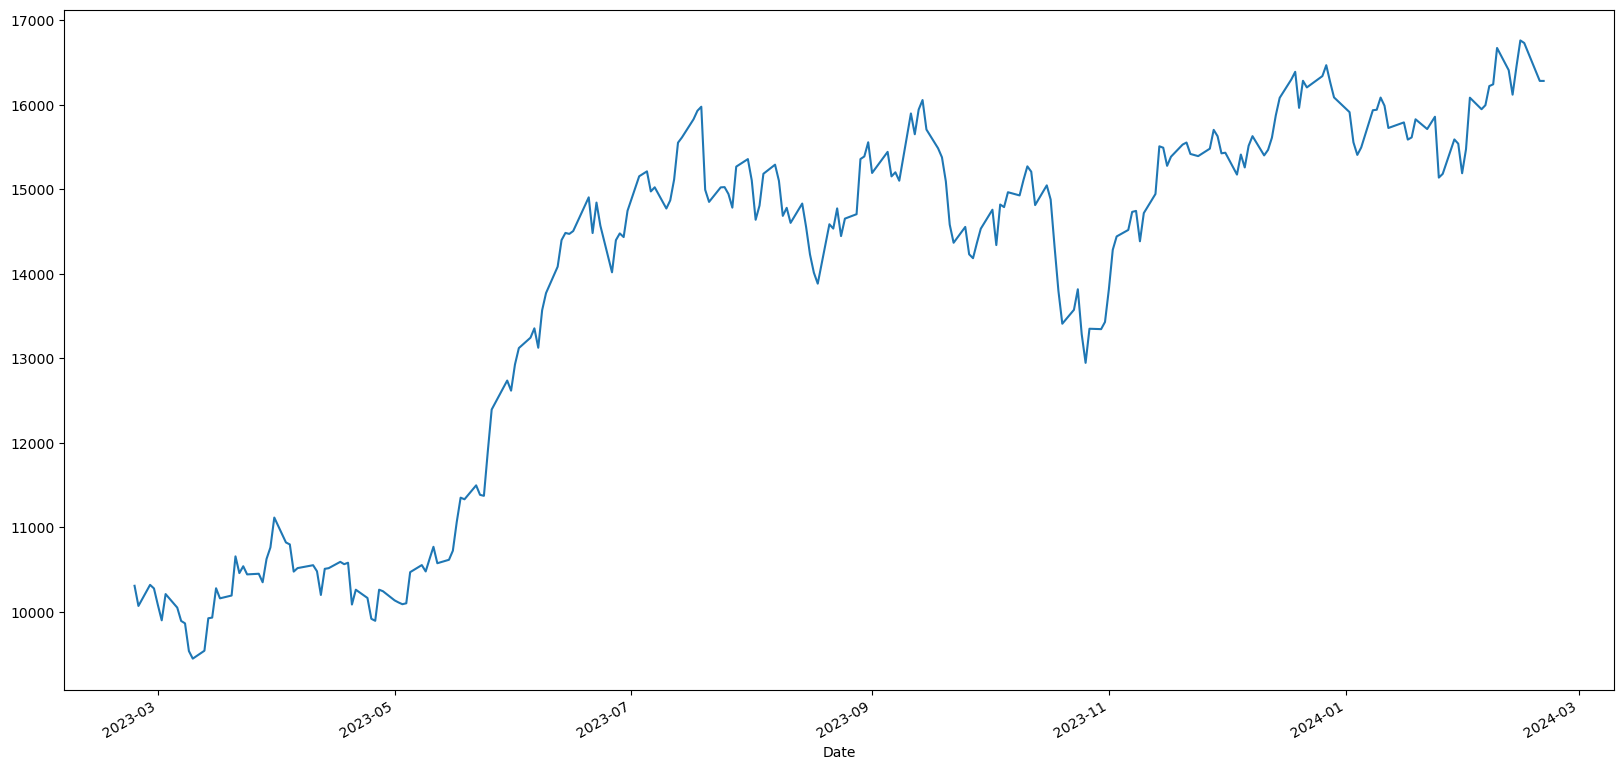

In [12]:
unoptimized_cumulative_returns = (1 + port_daily_return).cumprod()
unoptimized_cumulative_profits = (initial_investment * unoptimized_cumulative_returns)
unoptimized_cumulative_profits.plot(figsize=(20,10))

In [13]:
# Reorder daily_returns so SP500 Benchmark is first col

In [14]:
daily_returns = daily_returns[['^GSPC','AMZN','NVDA','TSLA']]
daily_returns

Ticker,^GSPC,AMZN,NVDA,TSLA
Date,,,,
2023-02-23,0.005329,0.000313,0.140214,0.006024
2023-02-24,-0.010538,-0.024212,-0.015974,-0.025684
2023-02-27,0.003073,0.002781,0.009233,0.054602
2023-02-28,-0.003036,0.005013,-0.012127,-0.009247
2023-03-01,-0.004725,-0.021861,-0.022312,-0.014292
...,...,...,...,...
2024-02-14,0.009580,0.013876,0.024567,0.025486
2024-02-15,0.005821,-0.006901,-0.016806,0.062212
2024-02-16,-0.004803,-0.001708,-0.000619,-0.002494


In [15]:
# Calculate betas of each ticker to SP500

In [16]:
def calc_beta(daily_returns):
    # benchmark = daily_returns['^GSPC']
    beta_list = {}
    portfolio = daily_returns.drop('^GSPC', axis=1)
    for ticker in portfolio:
        covariance = daily_returns[ticker].cov(daily_returns['^GSPC'])
        variance = daily_returns['^GSPC'].var()
        beta = covariance / variance
        beta_list[ticker] = beta
    beta_df = pd.DataFrame.from_dict(beta_list, orient='index')
    beta_df.columns = ['Beta']
    return beta_df

In [17]:
betas = calc_beta(daily_returns)
betas

,Beta
AMZN,1.463219
NVDA,1.962208
TSLA,2.150785


In [18]:
# Calculate New Portfolio Weights Based on Stock Betas


https://www.quora.com/Corporate-Finance-If-you-are-given-a-beta-how-do-you-determine-portfolio-weights

1. Calculate the beta of each stock in the portfolio: The beta can be obtained from financial databases, such as Morningstar or Yahoo Finance.

2. Determine the target market beta: The market beta can be estimated using an index such as the S&P 500, which has a beta of approximately 1.

3. Calculate the weight of each stock: The weight of each stock in the portfolio can be determined using the following formula:Stock weight = (Target market beta - Stock beta) / (Sum of all stock betas - Number of stocks)This formula ensures that the portfolio beta will equal the target market beta.

4. Normalize the weights: To ensure that the weights sum up to 1, divide each weight by the sum of all weights.

5. Rebalance the portfolio: Over time, the beta of a portfolio may change due to stock price movements or changes in the beta of individual stocks. To maintain the desired beta, the portfolio should be regularly rebalanced to adjust the weights.



In [19]:
def calc_beta_weights(df):
    beta_weights = {}
    target_market_beta = 1
    number_of_stocks = len(df)
    sum_of_all_stock_betas = df.sum()
    
    for index, row in df.iterrows():
        numerator = target_market_beta - row
        denominator = sum_of_all_stock_betas - number_of_stocks
        stock_weight = numerator / denominator
        beta_weights[index] = stock_weight
        
    beta_weights_df = pd.DataFrame.from_dict(beta_weights, orient='index')
    beta_weights_df_normalized = beta_weights_df['Beta'] / beta_weights_df['Beta'].sum()
    
    return beta_weights_df_normalized

In [20]:
calc_beta_weights(betas)

AMZN    0.179806
NVDA    0.373497
TSLA    0.446697
Name: Beta, dtype: float64